# Warehouse Robot on a Slippery Floor

<a class="anchor" id="Toc"><a>
# Table of Content
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Define useful classes](#define_useful_classes)
1. [Create ConnectX environment](#create_connectx_environment)
1. [Configure hyper-parameters](#configure_hyper_parameters)
1. [Train the agent](#train_the_agent)
1. [Create an agent](#create_an_agent)
1. [Evaluate the agent](#evaluate_the_agent)


<a class="anchor" id="install_libraries"></a>
# Install libraries

In [27]:
#pip install gymnasium pygame numpy matplotlib

<a class="anchor" id="import_libraries"></a>
# Import libraries

In [58]:
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import display, clear_output
import time
import networkx as nx


## Create and Inspect

In [ ]:
# Initialize the environment
def get_env(env_name: str, map_name: str, is_slippery: bool, render_mode: str):
    env = gym.make(env_name, map_name=map_name, is_slippery=is_slippery, render_mode=render_mode)
    return env

env = get_env("FrozenLake-v1", "8x8", True, "rgb_array")

# basic info
print("Action space size:", env.action_space.n)
print("Observation space size:", env.observation_space.n)

Action space size: 4
Observation space size: 64


Episode finished with reward: 0


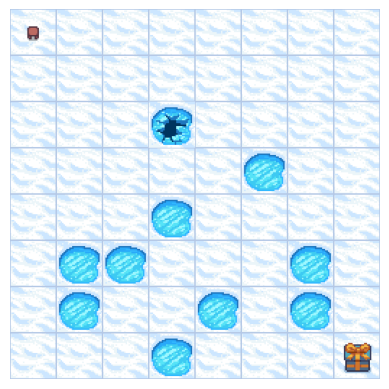

In [48]:
# Test and Visualize a random episode
def run_random_episode(env):
    plt.ion()
    animation_speed = 0.5  # seconds between frames
    state, info = env.reset()
    done = False
    step_count = 0
    while not done:
        step_count += 1
        action = env.action_space.sample()  # Take a random action
        state, reward, done, truncated, info = env.step(action)
        img = env.render()
        plt.imshow(img)
        plt.axis('off')
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(animation_speed)
        if done:
            clear_output(wait=False)
        if step_count > 30:  # Prevent infinite loops
            print("Episode terminated after 30 steps.")
            break
    print(f"Episode finished with reward: {reward}")

run_random_episode(env)

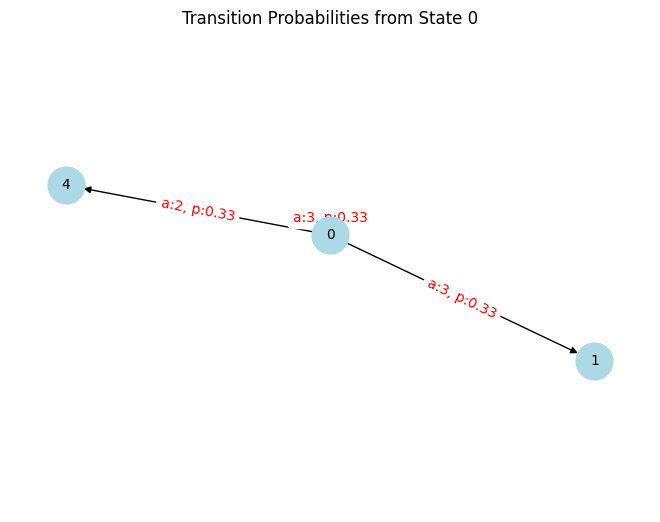

In [59]:
def inspect_transition_probabilities(env, state: int):
    env_raw = env.unwrapped
    G = nx.DiGraph()
    for action in range(env.action_space.n):
        transitions = env_raw.P[state][action]
        for prob, next_state, reward, done in transitions:
            if prob > 0:
                G.add_edge(state, next_state, action=action, weight=prob)
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): f"a:{d['action']}, p:{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(f"Transition Probabilities from State {state}")
    plt.show()
inspect_transition_probabilities(env, state=0)